## BloomTech Data Science

---


# Ridge Regression
- Do one-hot encoding of categorical features
- Use scikit-learn to fit Ridge Regression models



In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.8 MB/s eta 0:00:00


In [33]:
# Model Building

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For encoding categorical data
from category_encoders import OneHotEncoder

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [35]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col = 'created').sort_index()

  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
          (df['price'] <= np.percentile(df['price'], 99.5)) &
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop high-cardinality categorical variables
  cutoff = 90
  drop_cols = [col for col in df.select_dtypes('object').columns
            if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle("https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Linear-Models/master/data/apartments/renthop-nyc.csv")

In [7]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df['balcony'].value_counts()

0    45865
1     2952
Name: balcony, dtype: int64

In [ ]:
# threshold = 10
# cols_to_drop = []
# for col in df:
#   if df[col].dtype == 'object':
#     if df[col].nunique() > threshold:
#       cols_to_drop.append(col)

# df.drop(columns=cols_to_drop, inplace=True)

In [10]:
# Add this or the one above to the data wrangling part

# cutoff = 90
# drop_cols = [col for col in df.select_dtypes('object').columns
#             if df[col].nunique() > cutoff]
# df.drop(columns=drop_cols, inplace=True)

# II. Split Data

Split **target vector** from **feature matrix**.

In [11]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [12]:
X.index.max(), X.index.min()

(Timestamp('2016-06-29 21:41:47'), Timestamp('2016-04-01 22:12:41'))

In [13]:
# Several masks to choose from

# mask = (X.index.month == 4) | (X.index.month == 5)
# mask = X.index.month < 6


In [14]:
# or apply the mask based on cut-off given below
cutoff = '2016-06-01'

mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [15]:
X_train.shape, y_train.shape

((31844, 29), (31844,))

In [16]:
X_test.shape, y_test.shape

((16973, 29), (16973,))

# III. Establish Baseline

In [ ]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

# IV. Build Models

In [21]:
# Step 1: Import your transformer class
# We did above ☝️

# Step 2: Insantiate your transformer
ohe = OneHotEncoder(use_cat_names=True)
# Step 3: Fit your transformer
ohe.fit(X_train)
# Step 4: Transform
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [22]:
XT_train.head(2)

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_medium,interest_level_low,elevator,cats_allowed,hardwood_floors,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**Model 1:** Regular ol' linear regression

In [23]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Model 2:** Ridge regression (regularization)

In [29]:
model_r = Ridge(alpha = 1.0) # hyperparameter
model_r.fit(XT_train, y_train)

Ridge()

# V. Check Metrics

In [24]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

LR training MAE: 673.1520184336139
LR test MAE: 676.1082270370589


In [30]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge training MAE: 672.664072658999
Ridge test MAE: 675.5149089564139


# Communicate results

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


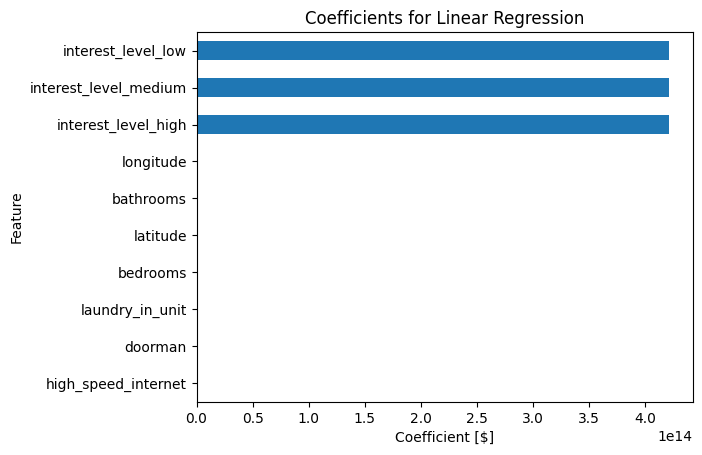

In [26]:
coefficients = model_lr.coef_
features = ohe.get_feature_names()

feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Linear Regression');

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


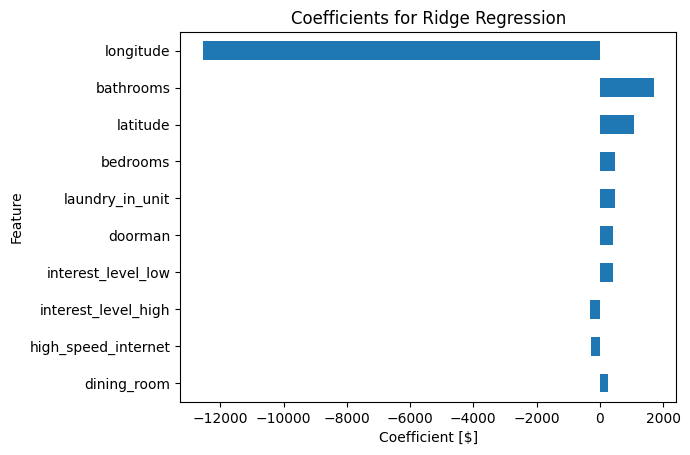

In [31]:
coefficients = model_r.coef_
features = ohe.get_feature_names()

feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');


In [36]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot('longitude', 'latitude', hue='price', data = df);


TypeError: ignored